In [1]:
import datetime
import os
import re

import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import griddata

from funcs.conv import conv_transaction_df2html
from funcs.setting import get_trend_footer, load_setting
from funcs.tide import (
    conv_date_str_to_path,
    get_date_dir_from_file,
    get_date_str_from_file_2,
    get_format_date_from_date_str,
)
from funcs.tse import get_ticker_name_list
from structs.res import AppRes

In [5]:
debug = False

res = AppRes()
date_str = "20260213"
# code = "4005"
code = "4689"
# code = "8410"
dict_setting = load_setting(res, code)
print(dict_setting)

if debug:
    base_dir = res.dir_temp
else:
    base_dir = res.dir_output

target_dir = os.path.join(base_dir, conv_date_str_to_path(date_str))
path_csv = os.path.join(target_dir, f"{code}_technicals.csv")
df = pd.read_csv(path_csv, index_col=0)
df.index = [pd.to_datetime(t) for t in df.index]
df

{'PERIOD_WARMUP': 300, 'PERIOD_MA_1': 30, 'LOSSCUT_1': -3.0, 'N_MINUS_MAX': 150, 'DD_PROFIT': 2.0, 'DD_RATIO': 0.9}


,ts,price,volume,vwap,ma1,cross1,profit,profit_max,drawdown,dd_ratio,n_minus,warmup
2026-02-13 09:00:05,1.770941e+09,400.7,2526000.0,400.700000,400.700000,0.0,0.0,0.0,0.0,0.0,0.0,1
2026-02-13 09:00:07,1.770941e+09,401.2,2565300.0,401.200000,400.950000,0.0,0.0,0.0,0.0,0.0,0.0,1
2026-02-13 09:00:09,1.770941e+09,401.7,2629800.0,401.510694,401.200000,0.0,0.0,0.0,0.0,0.0,0.0,1
2026-02-13 09:00:11,1.770941e+09,401.7,2629800.0,401.510694,401.325000,0.0,0.0,0.0,0.0,0.0,0.0,1
2026-02-13 09:00:13,1.770941e+09,402.0,2665700.0,401.636435,401.460000,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2026-02-13 15:24:40,1.770964e+09,388.7,29434000.0,391.319291,388.763333,0.0,0.0,0.0,0.0,0.0,0.0,0
2026-02-13 15:24:42,1.770964e+09,388.9,29435300.0,391.319174,388.763333,0.0,0.0,0.0,0.0,0.0,0.0,0
2026-02-13 15:24:44,1.770964e+09,388.7,29436300.0,391.319076,388.756667,0.0,0.0,0.0,0.0,0.0,0.0,0
2026-02-13 15:24:46,1.770964e+09,388.7,29436300.0,391.319076,388.756667,0.0,0.0,0.0,0.0,0.0,0.0,0


In [6]:
# Matplotlib の共通設定
FONT_PATH = "fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()

# of cross: 4
output/2026/02/13/4689_trend_technical.png


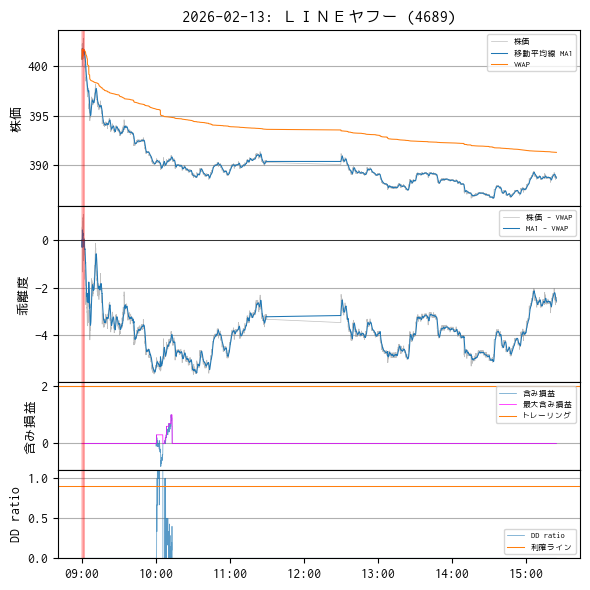

In [7]:
n = 4

if n == 1:
    fig, ax = plt.subplots(figsize=(6, 3))
    ax.grid(axis="y")
else:
    fig = plt.figure(figsize=(6, 6))
    ax = dict()
    gs = fig.add_gridspec(
        n,
        1,
        wspace=0.0,
        hspace=0.0,
        height_ratios=[2 if i <= 1 else 1 for i in range(n)],
    )
    for i, axis in enumerate(gs.subplots(sharex="col")):
        ax[i] = axis
        ax[i].grid(axis="y")

name = get_ticker_name_list([code])[code]
format_date = get_format_date_from_date_str(date_str)
ax[0].set_title(f"{format_date}: {name} ({code})")
ax[0].plot(df["price"], linewidth=0.5, color="gray", alpha=0.5, label="株価")
ax[0].plot(df["ma1"], linewidth=0.75, color="C0", label="移動平均線 MA1")
ax[0].plot(df["vwap"], linewidth=0.75, color="C1", label="VWAP")
# ax[0].set_xlabel(title_str, fontsize=5)
ax[0].set_ylabel("株価")
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax[0].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax[0].legend(fontsize=6)

ax[1].plot(
    df["price"] - df["vwap"],
    linewidth=0.5,
    color="gray",
    alpha=0.5,
    label="株価 - VWAP",
)
ax[1].plot(df["ma1"] - df["vwap"], linewidth=0.75, color="C0", label="MA1 - VWAP")
ax[1].axhline(y=0, linewidth=0.5, color="black")
ax[1].set_ylabel("乖離度")
ax[1].legend(fontsize=6)

ax[2].plot(df["profit"], linewidth=0.5, color="C0", alpha=0.75, label="含み損益")
ax[2].plot(df["profit_max"], linewidth=0.5, color="magenta", label="最大含み損益")
ax[2].axhline(
    y=dict_setting["DD_PROFIT"],
    linewidth=0.75,
    color="C1",
    alpha=1,
    label="トレーリング",
)
ax[2].set_ylabel("含み損益")
ax[2].legend(fontsize=6)

ax[3].plot(df["dd_ratio"], linewidth=0.5, color="C0", alpha=0.75, label="DD ratio")
ax[3].axhline(
    y=dict_setting["DD_RATIO"], linewidth=0.75, color="C1", label="利確ライン"
)
ax[3].set_ylabel("DD ratio")
ax[3].legend(fontsize=6)
ax[3].set_ylim(0, 1.1)

list_cross = df[df["cross1"] != 0].index
print(f"# of cross: {len(list_cross)}")
for i in range(n):
    for t in list_cross:
        ax[i].axvline(x=t, color="red", linestyle="solid", linewidth=0.25)

# plt.suptitle(title_str, fontsize=5)
plt.tight_layout()
# plt.subplots_adjust(top=0.89)
output = os.path.join(target_dir, f"{code}_trend_technical.png")
print(output)
plt.savefig(output)
plt.show()